In [1]:
import numpy as np
import matplotlib.pyplot as plt
import nbimporter

import central_system as cs
import analyze_control as ac

import exp_study_case
import exp_external_conditions
import exp_system_spec
import exp_house_spec
import exp_general_property
import exp_occupant_usage
import exp_circulating_air_flow

Importing Jupyter notebook from exp_study_case.ipynb
Importing Jupyter notebook from exp_external_conditions.ipynb
Importing Jupyter notebook from exp_system_spec.ipynb
Importing Jupyter notebook from exp_house_spec.ipynb
Importing Jupyter notebook from exp_general_property.ipynb
Importing Jupyter notebook from exp_occupant_usage.ipynb
Importing Jupyter notebook from exp_circulating_air_flow.ipynb


# 0. 検討ケース

試算するケースを取得します。

In [2]:
case = exp_study_case.get_case()
case

{'region': 6,
 'house': {'a_mr': 29.81,
  'a_or': 51.34,
  'a_a': 120.08,
  'r_env': 2.9555555555555557,
  'insulation': 'h11',
  'solar_gain': 'middle'},
 'system': {'default_heat_source_spec': True,
  'v_hs_rtd_h': 1800.0,
  'v_hs_rtd_c': 1800.0,
  'is_duct_insulated': True,
  'vav_system': False,
  'cap_rtd_h': None,
  'cap_rtd_c': None}}

1日グラフを描画する日を取得します。

In [3]:
hday, cday = exp_study_case.get_display_day()
hday, cday

('2/23', '9/1')

## 1. 外部モジュールの読み込み

### 熱源機の仕様

外部モジュール exp_system_spec を参照のこと。

$q_{rtd,H}$：定格暖房能力, W  
$q_{rtd,C}$：定格冷房能力, W  
$V_{hs,rtd,H}$：熱源機の暖房時の定格風量, m<sup>3</sup>/h  
$V_{hs,rtd,C}$：熱源機の冷房時の定格風量, m<sup>3</sup>/h  

In [4]:
q_rtd_h, q_rtd_c, v_hs_rtd_h, v_hs_rtd_c, is_duct_insulated, vav_system = \
    exp_system_spec.get_system_spec(case['region'], case['house']['a_a'], case['system'])

q_rtd_h, q_rtd_c, v_hs_rtd_h, v_hs_rtd_c, is_duct_insulated, vav_system

(7733.9925600000015, 7664.646360000001, 1800.0, 1800.0, True, False)

### 住宅の仕様

外部モジュール exp_house_spec を参照のこと。  

$r_{env}$：床面積の合計に対する外皮の部位の面積の合計の比  
$A_A$：床面積の合計, m<sup>2</sup>  
$A_{MR}$：主たる居室の床面積, m<sup>2</sup>  
$A_{OR}$：その他の居室の床面積, m<sup>2</sup>  
$A_{NR}$：非居室の床面積, m<sup>2</sup>  
$A_{HCZ,R,i}$：標準住戸における暖冷房区画 $i$ の床面積, m<sup>2</sup>  
$A_{HCZ,i}$：暖冷房区画 $i$ の床面積, m<sup>2</sup>  
$A_{prt,i}$：暖冷房区画 $i$ から見た非暖冷房空間の間仕切りの面積, m<sup>2</sup>  
$U_{prt}$：間仕切りの熱貫流率, W/m<sup>2</sup>K  
$Q$：熱損失係数, W/m<sup>2</sup>K  
$\mu_H$：暖房期の日射取得係数, ((W/m<sup>2</sup>)/(W/m<sup>2</sup>))  
$\mu_C$：冷房期の日射取得係数, ((W/m<sup>2</sup>)/(W/m<sup>2</sup>))  
$V_{vent,i}$：暖冷房区画 $i$ の機械換気量, m<sup>3</sup>/h  

In [5]:
r_env, a_a, a_mr, a_or, a_nr, a_hcz, a_prt, u_prt, q, mu_h, mu_c, v_vent = \
    exp_house_spec.get_house_spec(case['region'], case['house'])
r_env, a_a, a_mr, a_or, a_nr, a_hcz, a_prt, u_prt, q, mu_h, mu_c, v_vent

(2.9555555555555557,
 120.08,
 29.81,
 51.34,
 38.92999999999999,
 array([29.81, 16.56, 13.25, 10.76, 10.77,  3.31,  1.66,  3.31, 13.25,
         4.97, 10.77,  1.66]),
 array([37.99636619, 27.7187943 , 22.17838312, 18.01052093, 18.02725933]),
 2.1739130434782608,
 2.7,
 0.101,
 0.062,
 array([60., 20., 40., 20., 20.]))

### 物性値

外部モジュール exp_general_property を参照のこと。

$\rho$：空気の密度, kg/m<sup>3</sup>  
$c$：空気の比熱, J/kgK  
$L_{wtr}$：水の蒸発潜熱, kJ/kg  
「平日」「休日」の別

In [6]:
rho, c, l_wtr, calender = exp_general_property.get_general_property()
rho, c, l_wtr, calender

(1.2,
 1006.0,
 2434.5296000000003,
 array(['休日', '休日', '休日', ..., '休日', '休日', '休日'], dtype=object))

### 気候条件

外部モジュール exp_external_conditions を参照のこと。

$\theta_{ex,d,t}$：日付$d$の時刻$t$における外気温度, ℃  
$x_{ex,d,t}$：日付$d$の時刻$t$における絶対湿度, kg/kg(DA)  
$h_{ex_d,t}$：日付$d$の時刻$t$における相対湿度, %  
$J_{d,t}$：日付$d$の時刻$t$における水平面全天日射量, W/m<sup>2</sup>  
$\theta_{SAT,d,t}$：日付$d$の時刻$t$における水平面における等価外気温度, ℃  

In [7]:
theta_ex, x_ex, h_ex, j, theta_sat = exp_external_conditions.get_external_conditions(case['region'])
theta_ex, x_ex, h_ex, j, theta_sat

(array([2.6, 2.9, 2.8, ..., 3.1, 2.7, 2.3]),
 array([0.0033, 0.0032, 0.0032, ..., 0.0032, 0.0032, 0.0032]),
 array([72.52135498, 68.85197153, 69.34240102, ..., 67.88267058,
        69.83672797, 71.8536949 ]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([2.6, 2.9, 2.8, ..., 3.1, 2.7, 2.3]))

### 居住者の使い方

外部モジュール exp_occupant_usage を参照のこと。

暖房期間  
冷房期間  
$n_{p,d,t}$：日付$d$の時刻$t$における在室人数  
$q_{gen,d,t}$：日付$d$の時刻$t$における内部発熱, W  
$w_{gen,d,t}$：日付$d$の時刻$t$における内部発湿, g/h  
$V_{local,d,t}$：日付$d$時刻$t$における局所換気量, m<sup>3</sup>/h  
$V_{local,MR,d,t}$：日付$d$時刻$t$における主たる居室の局所換気量, m<sup>3</sup>/h  
$V_{local,OR,d,t}$：日付$d$時刻$t$におけるその他の居室の局所換気量, m<sup>3</sup>/h  
$V_{local,NR,d,t}$：日付$d$時刻$t$における非居室の局所換気量, m<sup>3</sup>/h  
$\theta_{set,h}$：暖房時の設定温度, ℃  
$\theta_{set,c}$：冷房時の設定温度, ℃  

In [8]:
heating_period, cooling_period, n_p, q_gen, w_gen, v_local, v_local_mr, v_local_or, v_local_nr, theta_set_h, theta_set_c \
    = exp_occupant_usage.get_occupant_usage(case['region'], a_mr, a_or, a_nr, calender)
heating_period, cooling_period, n_p, q_gen, w_gen, v_local, v_local_mr, v_local_or, v_local_nr, theta_set_h, theta_set_c

(array([ True,  True,  True, ...,  True,  True,  True]),
 array([False, False, False, ..., False, False, False]),
 array([4., 4., 4., ..., 4., 3., 3.]),
 array([126.4, 126.4, 126.4, ..., 763. , 815. , 242.7]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([  0. ,   0. ,   0. , ...,  25. ,  27. , 100.8]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([  0. ,   0. ,   0. , ...,  25. ,  27. , 100.8]),
 20.0,
 27.0)

### 循環風量

外部モジュール exp_circulating_air_flow を参照のこと。

$r_{supply,des,i}$：暖冷房区画 $i$ の風量バランス  
$V'_{supply,d,t,i}$：日付 $d$ の時刻 $t$ における暖冷房区画 $i$ へのVAV調整前の吹き出し風量, m<sup>3</sup>/h  

In [9]:
v_d_supply = exp_circulating_air_flow.get_circulating_air_flow(
    a_a, a_hcz, q, mu_h, mu_c, v_vent, theta_ex, x_ex, j, heating_period, cooling_period, n_p, q_gen, w_gen, v_local, theta_set_h, theta_set_c,
    q_rtd_h, q_rtd_c, v_hs_rtd_h, v_hs_rtd_c)
v_d_supply

array([[468.11565231, 460.46390045, 463.0144844 , ..., 416.81045706,
        430.28097496, 519.46598863],
       [260.04680316, 255.79611511, 257.21301113, ..., 231.54582922,
        239.02894818, 288.5728538 ],
       [208.06884915, 204.66778534, 205.80147328, ..., 185.26462785,
        191.25202678, 230.89313483],
       [168.96760882, 166.20568832, 167.12632849, ..., 150.44886005,
        155.31107986, 187.50265138],
       [169.12464191, 166.36015458, 167.28165035, ..., 150.58868241,
        155.45542101, 187.67691035]])

## 2. 暖冷房負荷

室 $i$ の暖房負荷 $L_{H,d,t,i}$ 、顕熱冷房負荷 $L_{CS,d,t,i}$ 、潜熱冷房負荷 $L_{CL,d,t,i}$ は、主たる居室・その他の居室の床面積、床面積の合計、断熱性能、日射熱取得性能に応じて決定される。（ここではいう負荷とは、室内環境の影響等の補正が入った後の負荷のことを言う。）

In [10]:
l_h, l_cs, l_cl = cs.get_load(region=case['region'], insulation=case['house']['insulation'], solar_gain=case['house']['solar_gain'],
                  a_mr=case['house']['a_mr'], a_or=case['house']['a_or'], a_a=case['house']['a_a'], r_env=case['house']['r_env'])

In [11]:
def make_list(load_data):

    return [(load_data[0], 'room 1'),
            (load_data[1], 'room 2'),
            (load_data[2], 'room 3'),
            (load_data[3], 'room 4'),
            (load_data[4], 'room 5'),
            (np.sum(load_data[0:5], axis=0), 'room 1-5'),
            (np.sum(load_data, axis=0), 'room 1-12')]

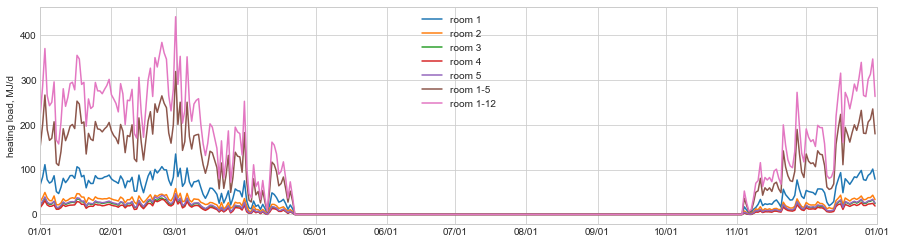

In [12]:
ac.draw_graph('heating load, MJ/d', make_list(l_h), 'itg')

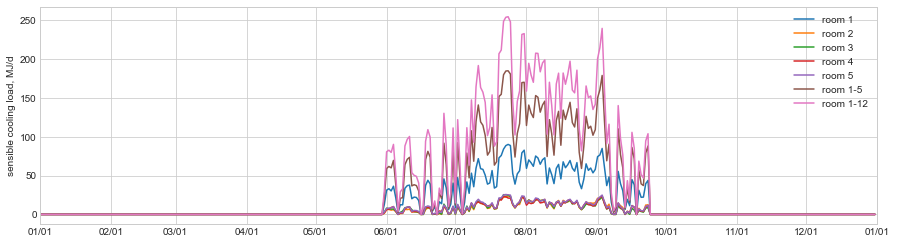

In [13]:
ac.draw_graph('sensible cooling load, MJ/d', make_list(l_cs), 'itg')

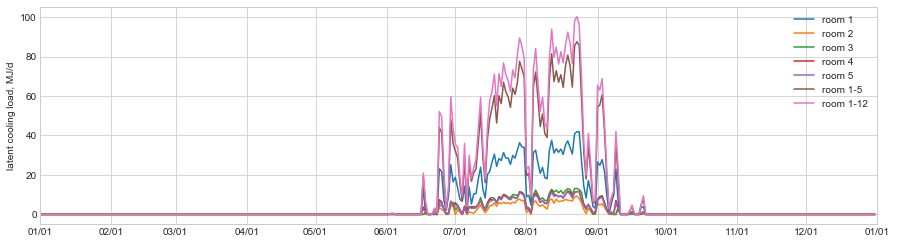

In [14]:
ac.draw_graph('latent cooling load, MJ/d', make_list(l_cl), 'itg')

## 3. 暖冷房室の温度

暖房時

$$ \theta_{ac,d,t} = \theta_{set,H} $$

冷房時

$$ \theta_{ac,d,t} = \theta_{set,C} $$

非暖冷房時

$$ \theta_{ac,d,t} = \left\{
\begin{array}{ll}
\theta_{ex,d,t} & \theta_{set,C,d,t} \ge \theta_{ex,d,t}, and \theta_{ex,d,t} \ge \theta_{set,H,d,t} \\
\theta_{set,C,d,t} & \theta_{ex,d,t} \gt \theta_{set,C,d,t} \\
\theta_{set,H,d,t} & \theta_{ac,H,d,t} \gt \theta_{set,d,t}
\end{array}
\right. $$

$\theta_{ac,d,t}$：日付 $d$ の時刻 $t$ における暖冷房室の温度, ℃  
$\theta_{set,H}$：暖房時の設定温度, ℃  
$\theta_{set,C}$：冷房時の設定温度, ℃  
$\theta_{ex,d,t}$：日付$d$の時刻$t$における外気温度, ℃  

In [15]:
theta_ac = cs.get_air_conditioned_room_temperature(heating_period, cooling_period, theta_ex, theta_set_h, theta_set_c)

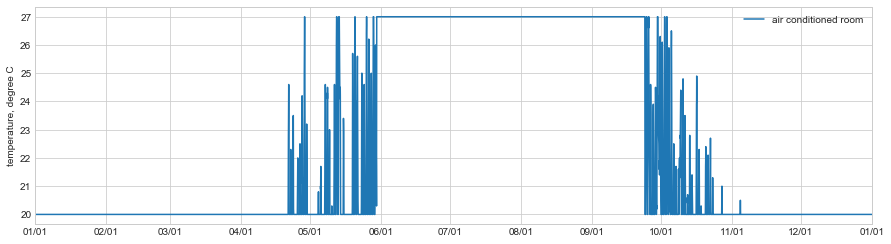

In [16]:
ac.draw_graph(y_title='temperature, degree C',
              ys=[(theta_ac, 'air conditioned room')],
              op='raw')

## 4. 非暖冷房室の温度

暖房時

$$ \theta'_{nac,d,t}
= \theta_{set,H} - \frac{L_{H,d,t}}
{
(Q - 0.35 \times 0.5 \times 2.4) A_{NR} + c \rho \frac{ V_{local,NR,d,t} }{ 3600 } + \sum_{i=1}^5{\left( c \rho \frac{ V'_{supply,d,t,i}  }{ 3600 } + U_{prt} A_{prt,i} \right) }
} \times \frac{10^6}{3600} $$

冷房時

$$ \theta'_{nac,d,t}
= \theta_{set,C} + \frac{L_{CS,d,t}}
{
(Q - 0.35 \times 0.5 \times 2.4) A_{NR} + c \rho \frac{ V_{local,NR,d,t} }{ 3600 } + \sum_{i=1}^5{\left( c \rho \frac{ V'_{supply,d,t,i}  }{ 3600 } + U_{prt} A_{prt,i} \right) }
} \times \frac{10^6}{3600} $$

中間期（非暖冷房時）

$$ \theta'_{nac,d,t} = \theta_{ac,d,t} $$

$\theta'_{nac,d,t}$：日付 $d$ の時刻 $t$ における負荷バランス時（※）の非暖冷房空間の温度, ℃  
$\theta_{set,H}$：暖房時の設定温度, ℃  
$\theta_{set,C}$：冷房時の設定温度, ℃  
$L_{H,d,t}$：日付 $d$ の時刻 $t$ における室 $i$ の暖房負荷, MJ/h  
$L_{CS,d,t}$：日付 $d$ の時刻 $t$ における室 $i$ の顕熱冷房負荷, MJ/h  
$Q$：熱損失係数, W/m<sup>2</sup>K  
$A_{NR}$：非居室の床面積, m<sup>2</sup>  
$c$：空気の比熱, J/kgK  
$\rho$：空気の密度, kg/m<sup>3</sup>  
$V_{local,NR,d,t}$：日付$d$時刻$t$における非居室の局所換気量, m<sup>3</sup>/h  
$V'_{supply,d,t,i}$：日付 $d$ の時刻 $t$ における暖冷房区画 $i$ へのVAV調整前の吹き出し風量, m<sup>3</sup>/h  
$U_{prt}$：間仕切りの熱貫流率, W/m<sup>2</sup>K  
$A_{prt,i}$：暖冷房区画 $i$ から見た非暖冷房空間の間仕切りの面積, m<sup>2</sup>  
$\theta_{ac,d,t}$：日付 $d$ の時刻 $t$ における暖冷房室の温度, ℃  

※　負荷バランス時：VAV等が導入されており、適切に負荷処理がなされ、暖冷房室の設定温度が過暖房（暖房時）又は過冷房（冷房時）になっていない場合のこと。負荷アンバランス時の場合は室温が設定温度よりも高温（暖房時）又は低温（冷房時）になる影響で非暖冷房室の温度も影響を受ける。（以下、同じ。）

In [17]:
theta_d_nac = cs.get_non_occupant_room_temperature_balanced(
    heating_period, cooling_period,
    l_h, l_cs, q, a_nr, v_local_nr, v_d_supply, u_prt, a_prt, theta_ac, theta_set_h, theta_set_c)

theta_d_nac

array([18.22650001, 18.21220063, 18.21209577, ..., 18.26895061,
       17.59949068, 18.40234349])

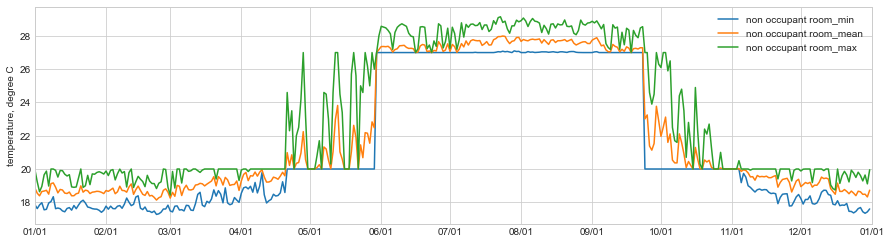

In [18]:
ac.draw_graph(y_title='temperature, degree C',
              ys=[(theta_d_nac, 'non occupant room')], op='a3')

#### （参考）式の導出（仕様書に記述する必要はない。）

非暖冷房室の熱バランスは以下のように表される。

$$ \left( (Q - 0.35 \times 0.5 \times 2.4) A_{NR} + c \rho \frac{ V_{local,NR,d,t} }{ 3600 } \right) (\theta_{ex,d,t} - \theta'_{nac,d,t}) + \mu A_{NR} J_{d,t} + q_{gen,NR,d,t} + n_{p,NR,d,t} q_{p} + \sum_{i=1}^5{\left( c \rho \frac{ V'_{supply,d,t,i}  }{ 3600 } + U_{prt} A_{prt,i} \right) } (\theta_{ac,d,t} - \theta'_{nac,d,t}) = 0 $$

ここで、  
$ \mu = \mu_H $ または $ \mu = \mu_C $、  
$ q_p = q_{p,H} $ または $ q_p = q_{p,C} $  
である。また、暖冷房時は、  
$ \theta_{ac,d,t} = \theta_{set,H} $ または $ \theta_{ac,d,t} = \theta_{set,C} $

これらに非定常性をいれて時々刻々と非暖冷房室の温度を解いていくことになるが、間仕切り間の熱移動が無い計算結果が現行評価方法の暖冷房負荷だとすると、以下が成り立つ。

$$ \left( (Q - 0.35 \times 0.5 \times 2.4) A_{NR} + c \rho \frac{ V_{local,NR,d,t} }{ 3600 } \right) (\theta_{ex,d,t} - \theta_{set,H}) + \mu_H A_{NR} J_{d,t} + q_{gen,NR,d,t} + n_{p,NR,d,t} q_{p,H} + \frac{L_{H,d,t}}{3600} \times 10^6 = 0 $$

$$ \left( (Q - 0.35 \times 0.5 \times 2.4) A_{NR} + c \rho \frac{ V_{local,NR,d,t} }{ 3600 } \right) (\theta_{ex,d,t} - \theta_{set,C}) + \mu_C A_{NR} J_{d,t} + q_{gen,NR,d,t} + n_{p,NR,d,t} q_{p,C} - \frac{L_{CS,d,t}}{3600} \times 10^6 = 0 $$

これを代入すると、

$$ \left( (Q - 0.35 \times 0.5 \times 2.4) A_{NR} + c \rho \frac{ V_{local,NR,d,t} }{ 3600 } \right) (\theta_{set,H} - \theta'_{nac,d,t}) - \frac{L_{H,d,t}}{3600} \times 10^6 + \sum_{i=1}^5{\left( c \rho \frac{ V'_{supply,d,t,i}  }{ 3600 } + U_{prt} A_{prt,i} \right) } (\theta_{set,H} - \theta'_{nac,d,t}) = 0 $$

$$ \left( (Q - 0.35 \times 0.5 \times 2.4) A_{NR} + c \rho \frac{ V_{local,NR,d,t} }{ 3600 } \right) (\theta_{set,C} - \theta'_{nac,d,t}) + \frac{L_{CS,d,t}}{3600} \times 10^6 + \sum_{i=1}^5{\left( c \rho \frac{ V'_{supply,d,t,i}  }{ 3600 } + U_{prt} A_{prt,i} \right) } (\theta_{set,C} - \theta'_{nac,d,t}) = 0 $$

となり、次式が得られる。

暖房時

$$ \theta'_{nac,d,t}
= \theta_{set,H} - \frac{L_{H,d,t}}
{
(Q - 0.35 \times 0.5 \times 2.4) A_{NR} + c \rho \frac{ V_{local,NR,d,t} }{ 3600 } + \sum_{i=1}^5{\left( c \rho \frac{ V'_{supply,d,t,i}  }{ 3600 } + U_{prt} A_{prt,i} \right) }
} \times \frac{10^6}{3600} $$

冷房時

$$ \theta'_{nac,d,t}
= \theta_{set,C} + \frac{L_{CS,d,t}}
{
(Q - 0.35 \times 0.5 \times 2.4) A_{NR} + c \rho \frac{ V_{local,NR,d,t} }{ 3600 } + \sum_{i=1}^5{\left( c \rho \frac{ V'_{supply,d,t,i}  }{ 3600 } + U_{prt} A_{prt,i} \right) }
} \times \frac{10^6}{3600} $$

中間期は暖冷房室同様に下記で与えられるものとする。

$$ \theta'_{nac,d,t} = \theta_{ex,d,t} $$

$\theta'_{nac,d,t}$：日付 $d$ の時刻 $t$ における負荷バランス時（※）の非暖冷房空間の温度, ℃  
$\theta_{set,H}$：暖房時の設定温度, ℃  
$\theta_{set,C}$：冷房時の設定温度, ℃  
$L_{H,d,t}$：日付 $d$ の時刻 $t$ における室 $i$ の暖房負荷, MJ/h  
$L_{CS,d,t}$：日付 $d$ の時刻 $t$ における室 $i$ の顕熱冷房負荷, MJ/h  
$Q$：熱損失係数, W/m<sup>2</sup>K  
$\mu_H$：暖房期の日射取得係数, ((W/m2)/(W/m2))
$\mu_C$：冷房期の日射取得係数, ((W/m2)/(W/m2))
$A_{NR}$：非居室の床面積, m<sup>2</sup>  
$c$：空気の比熱, J/kgK  
$\rho$：空気の密度, kg/m<sup>3</sup>  
$V_{local,NR,d,t}$：日付$d$時刻$t$における非居室の局所換気量, m<sup>3</sup>/h  
$V'_{supply,d,t,i}$：日付 $d$ の時刻 $t$ における暖冷房区画 $i$ へのVAV調整前の吹き出し風量, m<sup>3</sup>/h  
$U_{prt}$：間仕切りの熱貫流率, W/m<sup>2</sup>K  
$A_{prt,i}$：暖冷房区画 $i$ から見た非暖冷房空間の間仕切りの面積, m<sup>2</sup>  
$q_{gen,NR,d,t}$：日付$d$の時刻$t$における非居室の内部発熱, W  
$n_{p,NR,d,t}$：日付$d$の時刻$t$における非居室の在室人数  
$q_{p,H}$：暖房期の居住者1人当りの顕熱発熱量, W  
$q_{p,CS}$：冷房期の居住者1人当りの顕熱発熱量, W  
$\theta_{ac,H}$：暖房時の暖冷房区画の温度, ℃  
$\theta_{ac,C}$：冷房時の暖冷房区画の温度, ℃  
$\theta_{ex,d,t}$：日付 $d$ の時刻 $t$ における外気温度, ℃  
$J_{d,t}$：日付 $d$ の時刻 $t$ における水平面全天日射量, W/m<sup>2</sup>  

※　負荷バランス時：VAV等が導入されており、適切に負荷処理がなされ、暖冷房室の設定温度が過暖房（暖房時）又は過冷房（冷房時）になっていない場合のこと。負荷アンバランス時の場合は室温が設定温度よりも高温（暖房時）又は低温（冷房時）になる影響で非暖冷房室の温度も影響を受ける。（以下、同じ。）

## 5. 暖冷房室（居室）から非暖冷房室（非居室）への熱移動（熱損失（暖房期）・熱取得（冷房期））

$$ Q'_{trs,prt,d,t,i} = U_{prt} A_{prt,i} \left( \theta_{ac,d,t} - \theta'_{nac,d,t} \right) \times 3600 \times 10^{-6} $$

$Q'_{trs,prt,d,t,i}$：日付 $d$ の時刻 $t$ における1時間当たりの暖冷房区画 $i$ から非暖冷房空間への負荷バランス時（※）の熱移動, MJ/h  
$U_{prt}$：間仕切りの熱貫流率, W/m<sup>2</sup>K  
$A_{prt,i}$：暖冷房区画 $i$ から見た非暖冷房空間の間仕切りの面積, m<sup>2</sup>  
$\theta_{ac,d,t}$：日付 $d$ の時刻 $t$ における暖冷房区画の温度, ℃  
$\theta'_{nac,d,t}$：日付 $d$ の時刻 $t$ における負荷バランス時（※）の非暖冷房空間の温度, ℃  

※ 同上

In [19]:
q_d_trs_prt = cs.get_heat_transfer_through_partition_balanced(u_prt, a_prt, theta_ac, theta_d_nac)

## 6. 暖冷房室（居室）の負荷

$$ L'_{H,d,t,i} = L_{H,d,t,i} + Q'_{trs,prt,H,d,t,i} $$

$$ L'_{CS,d,t,i} = L_{CS,d,t,i} + Q'_{trs,prt,C,d,t,i} $$

$$ L'_{CL,d,t,i} = L_{CL,d,t,i} $$

ただし、  
$L_{H,d,t,i} = 0$の場合は$L'_{H,d,t,i} = 0$ とする。  
$L'_{H,d,t,i}$が0を下回る場合は0とする。  
$L_{CS,d,t,i} = 0$の場合は$L'_{CS,d,t,i} = 0$ とする。  
$L'_{CS,d,t,i}$が0を下回る場合は0とする。  
$L'_{CL,d,t,i}$が0を下回る場合は0とする。  

$L'_{H,d,t,i}$：日付 $d$ の時刻 $t$ における室 $i$ の1時間当たりの負荷バランス時（※）の間仕切り熱損失を含む暖房負荷, MJ/h  
$L'_{CS,d,t,i}$：日付 $d$ の時刻 $t$ における室 $i$ の1時間当たりの負荷バランス時（※）の間仕切り熱取得を含む顕熱冷房負荷, MJ/h  
$L'_{CL,d,t,i}$：日付 $d$ の時刻 $t$ における室 $i$ の1時間当たりの負荷バランス時（※）の間仕切り熱取得を含む潜熱冷房負荷, MJ/h  
$L_{H,d,t,i}$：日付 $d$ の時刻 $t$ における室 $i$ の1時間当たりの暖房負荷, MJ/h  
$L_{CS,d,t,i}$：日付 $d$ の時刻 $t$ における室 $i$ の1時間当たりの顕熱冷房負荷, MJ/h  
$L_{CL,d,t,i}$：日付 $d$ の時刻 $t$ における室 $i$ の1時間当たりの潜熱冷房負荷, MJ/h  
$Q'_{trs,prt,H,d,t,i}$：日付 $d$ の時刻 $t$ における1時間当たりの暖冷房区画 $i$ から非暖冷房空間への負荷バランス時（※）の貫流熱損失, MJ/h  
$Q'_{trs,prt,C,d,t,i}$：日付 $d$ の時刻 $t$ における1時間当たりの非暖冷房空間から暖冷房区画 $i$ への負荷バランス時（※）の貫流熱取得, MJ/h  

In [20]:
l_d_h = cs.get_occupant_room_load_for_heating_balanced(l_h, q_d_trs_prt)
l_d_cs, l_d_cl = cs.get_occupant_room_load_for_cooling_balanced(l_cs, l_cl, q_d_trs_prt)

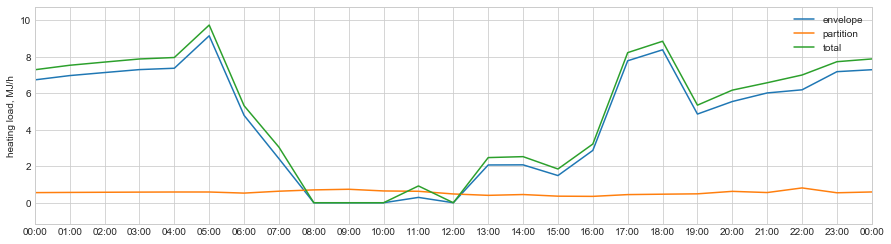

In [21]:
ac.draw_graph(y_title='heating load, MJ/h',
              ys=[(l_h[0], 'envelope'), (q_d_trs_prt[0], 'partition'), (l_d_h[0], 'total')], op='raw', display_date=hday)

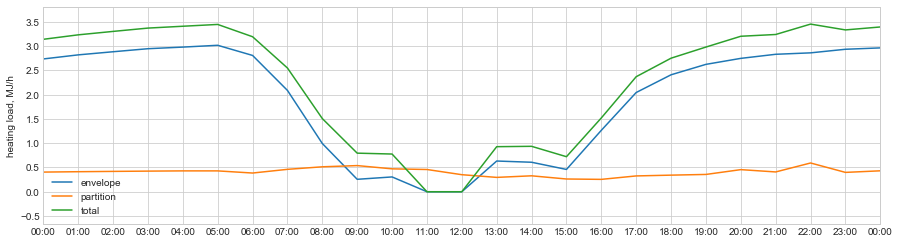

In [22]:
ac.draw_graph(y_title='heating load, MJ/h',
              ys=[(l_h[1], 'envelope'), (q_d_trs_prt[1], 'partition'), (l_d_h[1], 'total')], op='raw', display_date=hday)

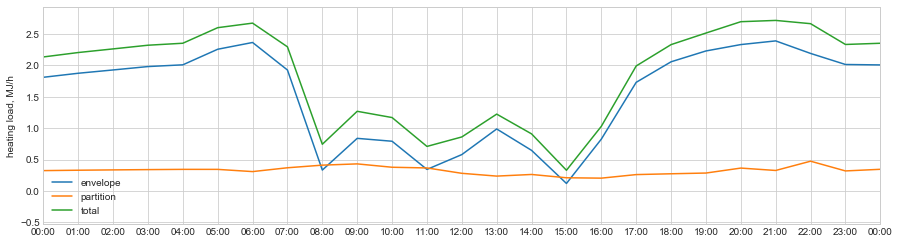

In [23]:
ac.draw_graph(y_title='heating load, MJ/h',
              ys=[(l_h[2], 'envelope'), (q_d_trs_prt[2], 'partition'), (l_d_h[2], 'total')], op='raw', display_date=hday)

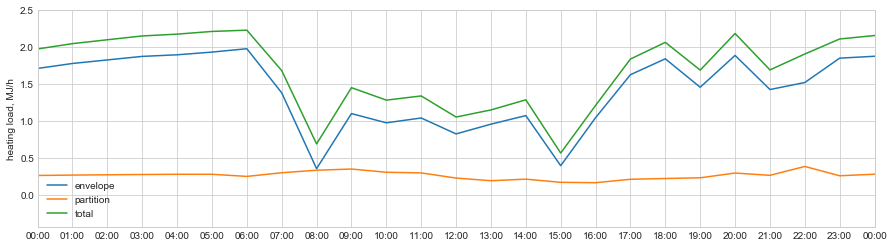

In [24]:
ac.draw_graph(y_title='heating load, MJ/h',
              ys=[(l_h[3], 'envelope'), (q_d_trs_prt[3], 'partition'), (l_d_h[3], 'total')], op='raw', display_date=hday)

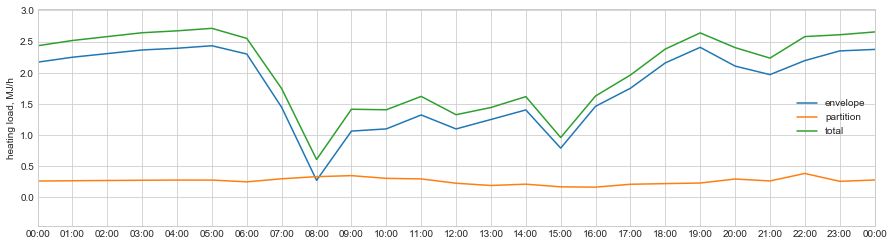

In [25]:
ac.draw_graph(y_title='heating load, MJ/h',
              ys=[(l_h[4], 'envelope'), (q_d_trs_prt[4], 'partition'), (l_d_h[4], 'total')], op='raw', display_date=hday)

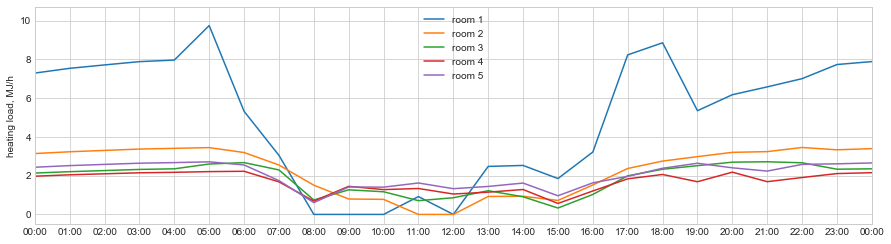

In [26]:
ac.draw_graph(y_title='heating load, MJ/h',
              ys=[
                  (l_d_h[0], 'room 1'),
                  (l_d_h[1], 'room 2'),
                  (l_d_h[2], 'room 3'),
                  (l_d_h[3], 'room 4'),
                  (l_d_h[4], 'room 5'),
              ], op='raw', display_date=hday)

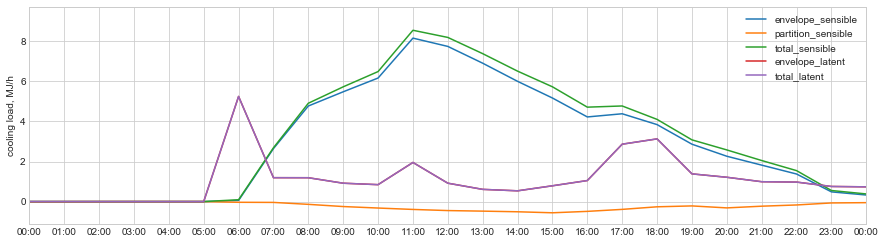

In [27]:
ac.draw_graph(y_title='cooling load, MJ/h',
              ys=[(l_cs[0], 'envelope_sensible'), (q_d_trs_prt[0], 'partition_sensible'), (l_d_cs[0], 'total_sensible'),
                  (l_cl[0], 'envelope_latent'), (l_d_cl[0], 'total_latent')], op='raw', display_date=cday)

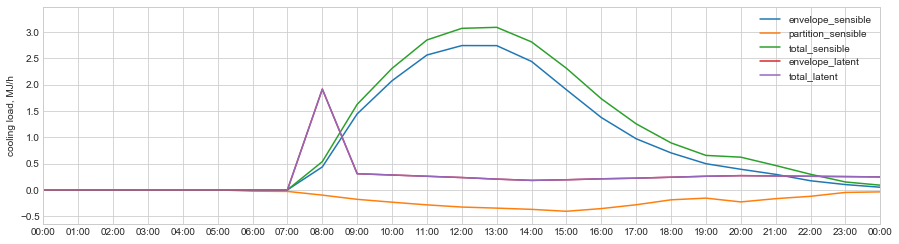

In [28]:
ac.draw_graph(y_title='cooling load, MJ/h',
              ys=[(l_cs[1], 'envelope_sensible'), (q_d_trs_prt[1], 'partition_sensible'), (l_d_cs[1], 'total_sensible'),
                  (l_cl[1], 'envelope_latent'), (l_d_cl[1], 'total_latent')], op='raw', display_date=cday)

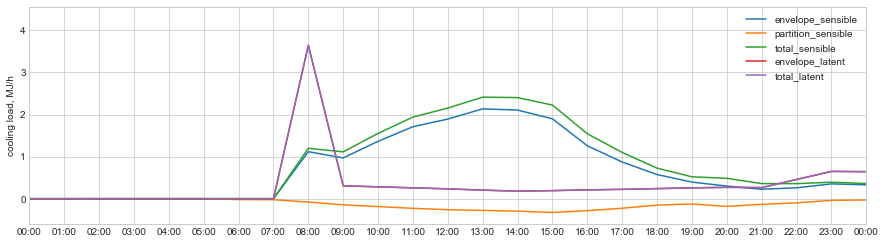

In [29]:
ac.draw_graph(y_title='cooling load, MJ/h',
              ys=[(l_cs[2], 'envelope_sensible'), (q_d_trs_prt[2], 'partition_sensible'), (l_d_cs[2], 'total_sensible'),
                  (l_cl[2], 'envelope_latent'), (l_d_cl[2], 'total_latent')], op='raw', display_date=cday)

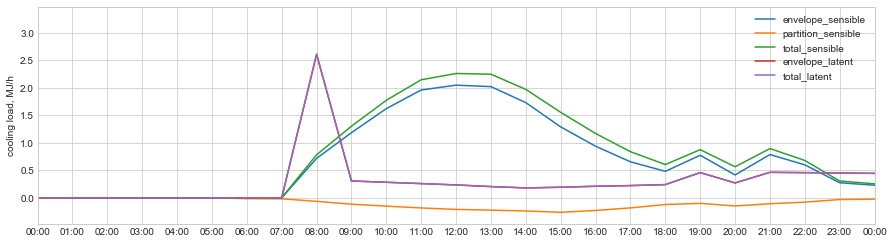

In [30]:
ac.draw_graph(y_title='cooling load, MJ/h',
              ys=[(l_cs[3], 'envelope_sensible'), (q_d_trs_prt[3], 'partition_sensible'), (l_d_cs[3], 'total_sensible'),
                  (l_cl[3], 'envelope_latent'), (l_d_cl[3], 'total_latent')], op='raw', display_date=cday)

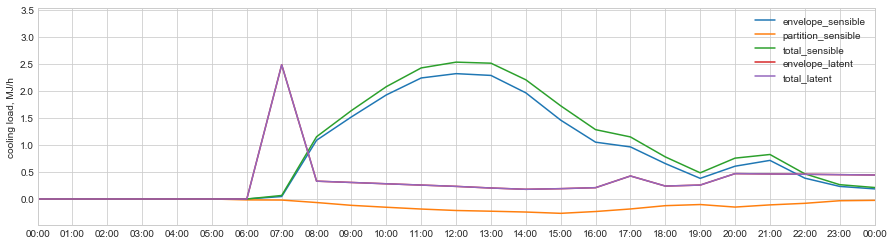

In [31]:
ac.draw_graph(y_title='cooling load, MJ/h',
              ys=[(l_cs[4], 'envelope_sensible'), (q_d_trs_prt[4], 'partition_sensible'), (l_d_cs[4], 'total_sensible'),
                  (l_cl[4], 'envelope_latent'), (l_d_cl[4], 'total_latent')], op='raw', display_date=cday)

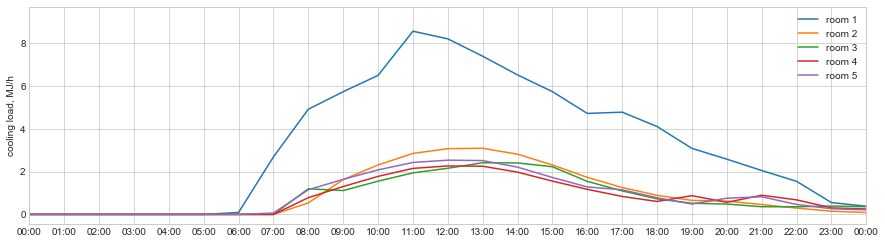

In [32]:
ac.draw_graph(y_title='cooling load, MJ/h',
              ys=[
                  (l_d_cs[0], 'room 1'),
                  (l_d_cs[1], 'room 2'),
                  (l_d_cs[2], 'room 3'),
                  (l_d_cs[3], 'room 4'),
                  (l_d_cs[4], 'room 5'),
              ], op='raw', display_date=cday)

## 3. 外部モジュールへの引き渡し

本モジュールを外部のモジュールから呼び出して必要な値を取得する場合に利用する関数を定義します。

In [33]:
def get_load(region, house_spec, heating_period, cooling_period, theta_ex, theta_set_h, theta_set_c,
            q, a_nr, v_local_nr, v_d_supply, u_prt, a_prt):
    
    l_h, l_cs, l_cl = cs.get_load(region=region, insulation=house_spec['insulation'], solar_gain=house_spec['solar_gain'],
                                  a_mr=house_spec['a_mr'], a_or=house_spec['a_or'], a_a=house_spec['a_a'], r_env=house_spec['r_env'])
    theta_ac = cs.get_air_conditioned_room_temperature(heating_period, cooling_period, theta_ex, theta_set_h, theta_set_c)

    theta_d_nac = cs.get_non_occupant_room_temperature_balanced(
        heating_period, cooling_period,
        l_h, l_cs, q, a_nr, v_local_nr, v_d_supply, u_prt, a_prt, theta_ac, theta_set_h, theta_set_c)
    
    q_d_trs_prt = cs.get_heat_transfer_through_partition_balanced(u_prt, a_prt, theta_ac, theta_d_nac)
    
    l_d_h = cs.get_occupant_room_load_for_heating_balanced(l_h, q_d_trs_prt)
    l_d_cs, l_d_cl = cs.get_occupant_room_load_for_cooling_balanced(l_cs, l_cl, q_d_trs_prt)
    
    return theta_ac, l_h, l_cs, l_cl, theta_d_nac, l_d_h, l_d_cs, l_d_cl